In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -o /content/drive/MyDrive/Classification-Dataset.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/Classification-Dataset/Non-recyclable/00000377.jpg  
  inflating: /content/Classification-Dataset/Non-recyclable/00000378.jpg  
  inflating: /content/Classification-Dataset/Non-recyclable/00000379.jpg  
  inflating: /content/Classification-Dataset/Non-recyclable/00000380.jpg  
  inflating: /content/Classification-Dataset/Non-recyclable/00000381.jpg  
  inflating: /content/Classification-Dataset/Non-recyclable/00000382.jpg  
  inflating: /content/Classification-Dataset/Non-recyclable/00000383.jpg  
  inflating: /content/Classification-Dataset/Non-recyclable/00000384.jpg  
  inflating: /content/Classification-Dataset/Non-recyclable/00000385.jpg  
  inflating: /content/Classification-Dataset/Non-recyclable/00000386.jpg  
  inflating: /content/Classification-Dataset/Non-recyclable/00000387.jpg  
  inflating: /content/Classification-Dataset/Non-recyclable/00000388.jpg  
  inflating: /content/Classification-Dataset/Non-

Training samples: 3668
Test samples: 917
Class Weights: {0: np.float64(1.1134045653229723), 1: np.float64(0.9075613618368963)}
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.6710 - loss: 0.6478 - val_accuracy: 0.7801 - val_loss: 0.4604
Epoch 2/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8031 - loss: 0.4384 - val_accuracy: 0.8337 - val_loss: 0.3958
Epoch 3/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8260 - loss: 0.3965 - val_accuracy: 0.8638 - val_loss: 0.3252
Epoch 4/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8670 - loss: 0.3293 - val_accuracy: 0.8650 - val_loss: 0.3244
Epoch 5/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8984 - loss: 0.2653 - val_accuracy: 0.8638 - val_loss: 0.2948
Epoch 6/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9183 - loss: 0.2156 - val_accuracy: 0.8460 - val_loss: 0.3643
Epoch 7/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9160 - loss: 0.2053 - val_accuracy: 0.8940 - val_loss: 0.2911
Epoch 8/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9481 - loss: 0.1486 - val_accuracy: 0.888

Model saved as recyclable_waste_cnn.h5
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8867 - loss: 0.3263
Test Accuracy: 88.55%
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


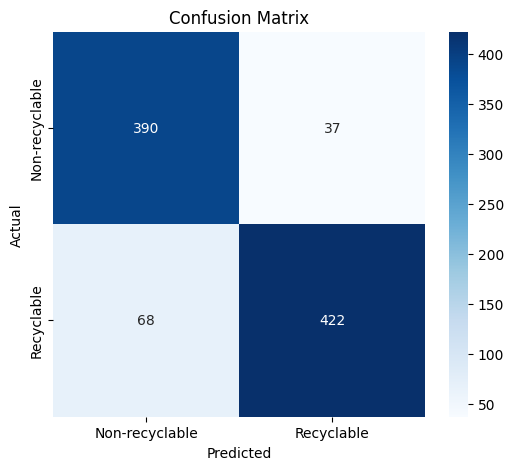

Classification Report:
                precision    recall  f1-score   support

Non-recyclable       0.85      0.91      0.88       427
    Recyclable       0.92      0.86      0.89       490

      accuracy                           0.89       917
     macro avg       0.89      0.89      0.89       917
  weighted avg       0.89      0.89      0.89       917

Enter path of image to classify: /content/Classification-Dataset/Non-recyclable/00000004.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
Non-Recyclable


In [5]:
import os
import numpy as np
import tensorflow as tf
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters
img_size = 128
BATCH_SIZE = 32
EPOCHS = 10
classes = ["Non-recyclable", "Recyclable"]
base_dir = "Classification-Dataset/"

# Convert PNG to JPG and skip XML
for cls in classes:
    folder = os.path.join(base_dir, cls)

    for file in os.listdir(folder):
        file_path = os.path.join(folder, file)

        if file.lower().endswith(".xml"):
            continue

        if file.lower().endswith(".png"):
            img = cv2.imread(file_path)
            if img is None:
                continue

            new_filename = file.rsplit(".", 1)[0] + ".jpg"
            new_path = os.path.join(folder, new_filename)

            cv2.imwrite(new_path, img, [cv2.IMWRITE_JPEG_QUALITY, 90])
            os.remove(file_path)

            print(f"Converted: {file} → {new_filename}")

# Load images
data = []
labels = []

for idx, cls in enumerate(classes):
    folder = os.path.join(base_dir, cls)
    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)

        img = cv2.imread(img_path)
        if img is None:
            continue

        img = cv2.resize(img, (img_size, img_size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img / 255.0

        data.append(img)
        labels.append(idx)

data = np.array(data, dtype="float32")
labels = np.array(labels)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42, shuffle=True
)

num_train_examples = X_train.shape[0]
num_test_examples = X_test.shape[0]

print(f"Training samples: {num_train_examples}")
print(f"Test samples: {num_test_examples}")

# TF dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

# Class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class Weights:", class_weights_dict)

# Build model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train model
steps_per_epoch = num_train_examples // BATCH_SIZE
validation_steps = num_test_examples // BATCH_SIZE

model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps,
    epochs=EPOCHS,
    class_weight=class_weights_dict
)

model.save("recyclable_waste_cnn.h5")
print("Model saved as recyclable_waste_cnn.h5")

# Evaluate model
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {accuracy*100:.2f}%")

# Confusion matrix
y_pred_prob = model.predict(test_dataset)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=classes,
            yticklabels=classes,
            cmap="Blues")

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=classes))

# Predict image
img_path = input("Enter path of image to classify: ")

img = cv2.imread(img_path)
img = cv2.resize(img, (img_size, img_size))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img / 255.0
img = np.expand_dims(img, axis=0)

pred = model.predict(img)[0][0]

if pred > 0.5:
    print("Recyclable")
else:
    print("Non-Recyclable")


Enter path of image to classify: /content/Classification-Dataset/Non-recyclable/00000004.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Non-Recyclable
Saved to prediction_result.txt


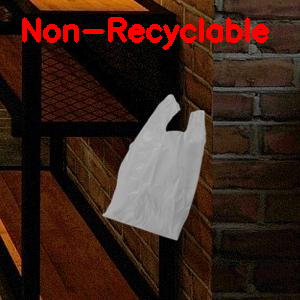

In [6]:
from google.colab.patches import cv2_imshow

# Predict image
img_path = input("Enter path of image to classify: ")

img = cv2.imread(img_path)
img_resized = cv2.resize(img, (img_size, img_size))
img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
img_norm = img_rgb / 255.0
img_input = np.expand_dims(img_norm, axis=0)

pred = model.predict(img_input)[0][0]

# Decide label
if pred > 0.5:
    result = "Recyclable"
    color = (0, 255, 0)  # green
else:
    result = "Non-Recyclable"
    color = (0, 0, 255)  # red

print(result)

# Save result to a file
with open("prediction_result.txt", "w") as f:
    f.write(f"Image: {img_path}\nPrediction: {result}\n")
print("Saved to prediction_result.txt")

# Show image with label (Colab-compatible)
cv2.putText(img, result, (20, 40),
            cv2.FONT_HERSHEY_SIMPLEX, 1, color, 3)
cv2_imshow(img)
